# DataRes Consulting Fall 2022

Project: Assisting a compnay called HomeDescription where we are going to use NLP to determine what factors are the most important in selling a house.  
Mostly going to look at factors such as the description (words), location, selling price, zestimate, & agencies

This notebook is for Exploratory Data Analysis

# Import Stuff

In [3]:
# Import all of the important packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from matplotlib.ticker import PercentFormatter

In [4]:
# Import the data and format it
data = pd.read_excel("ZILLOW_DATA_CA_22-02-2022.xlsx")
data.columns = data.iloc[0, :]
data.drop(data.index[0], inplace = True)

# Cleaning Data a Little

In [5]:
# Takes only the Single Family Homes (20,000) and the properties that have been sold (19,331 entries total)
single_families_home = data[(data["Property Type"] == "SINGLE_FAMILY") & (data["Property Status"] == "RECENTLY_SOLD")]

# only takes most important vars: Zipcode, living area (Sqaure Feet), Price (USD), and Days on Zillow
important = single_families_home[["Zipcode", "Living Area", "Price", "Days On Zillow"]]

In [6]:
# Including Zip Code
zip_code = important.groupby(["Zipcode", pd.cut(important["Living Area"], np.arange(1000, 5001, 1000)), pd.cut(important["Price"], np.arange(600000, 3100000, 200000))])[["Days On Zillow"]].mean().reset_index()
zip_code = zip_code.dropna()

# More bins and contains more information
zip_code2 = important.groupby(["Zipcode", pd.cut(important["Living Area"], np.arange(0, 6001, 1000)), pd.cut(important["Price"], np.arange(0, 3300000, 200000))])[["Days On Zillow"]].mean().reset_index()

# Not including Zip Code
groupby_area_price = important.groupby([pd.cut(important["Living Area"], np.arange(1000, 5001, 1000)), pd.cut(important["Price"], np.arange(600000, 3100000, 200000))])[["Days On Zillow"]].mean().reset_index()
groupby_area_price = groupby_area_price.dropna()

# More bins and contains more information
groupby_area_price2 = important.groupby([pd.cut(important["Living Area"], np.arange(0, 6001, 1000)), pd.cut(important["Price"], np.arange(0, 3300000, 200000))])[["Days On Zillow"]].mean().reset_index()

# Comparing Single Family Homes: Separate by Price, location, and size

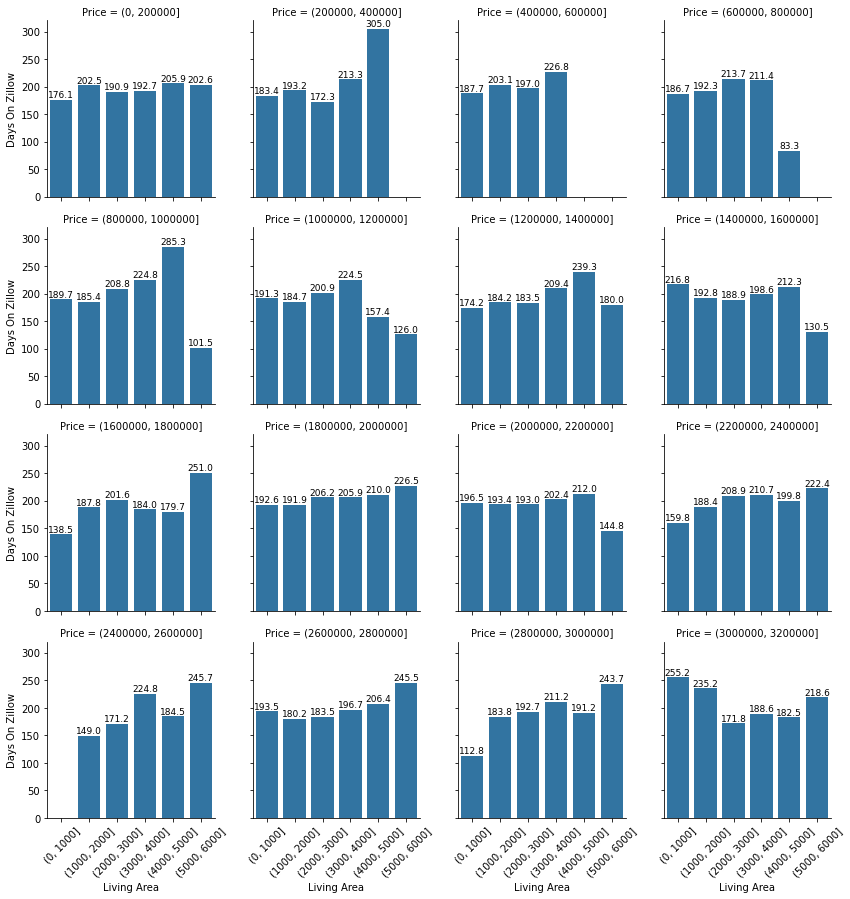

In [11]:
import warnings
warnings.filterwarnings("ignore")

g = sns.FacetGrid(groupby_area_price2, col = "Price", col_wrap = 4)
g = g.map(sns.barplot, "Living Area", "Days On Zillow")
g.set_xticklabels(rotation = 45)

for ax in g.axes:
    for p in ax.patches:
             ax.annotate("%.1f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                 textcoords='offset points')

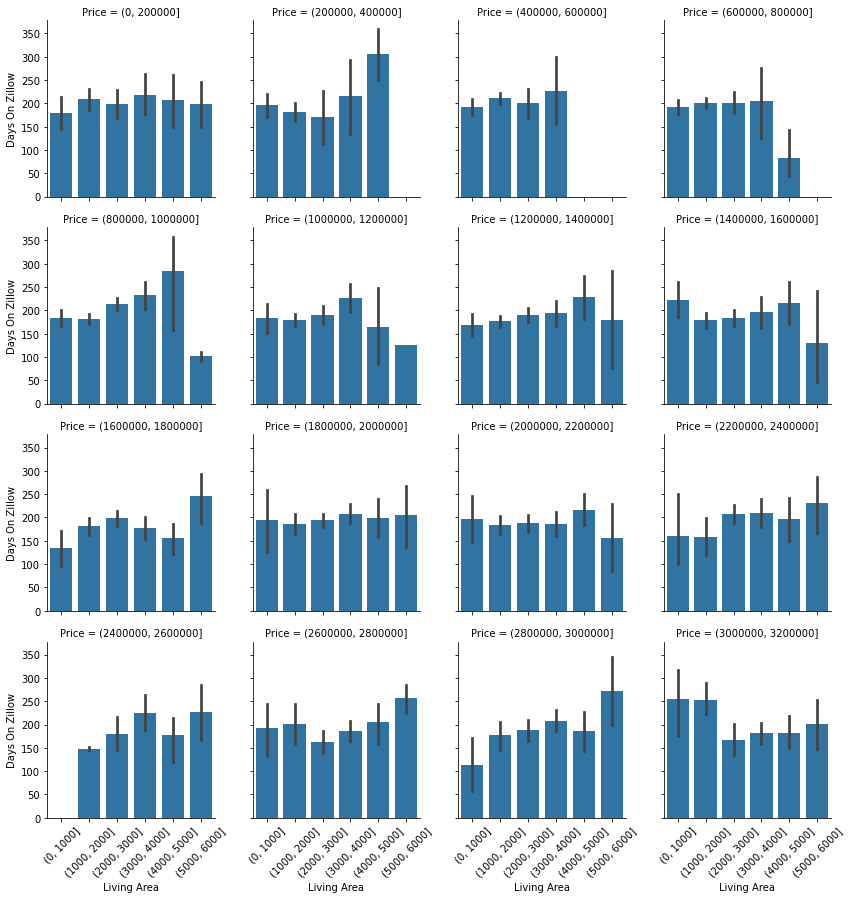

In [6]:
g = sns.FacetGrid(zip_code2, col = "Price", col_wrap = 4)
g.map(sns.barplot, "Living Area", "Days On Zillow")
g.set_xticklabels(rotation = 45)

What I got from these graphs above: 
* Seems like in general, houses that are smaller stay on the market for less time
* Houses in different zipcodes don't seem to differ (in terms of days on Zillow) too much unless the house is very large or very expensive
* Larger houses have more variance in terms of how long it will stay on Zillow
* Cheap vs. Expensive house doesn't really affect how long it will stay on the market for the most part

# Making a Map

In [6]:
# Import things to display map
import folium
import json
from folium import plugins
import branca
import math

In [292]:
# Around 20,000 Entries
sample_data = single_families_home.sample(5000)

# opens the original map
with open('laMap.geojson') as f:
    laArea = json.load(f)

# General location of the map to start at
laMap = folium.Map(location=[34.052235, -118.243683],  zoom_start=9)

#add the shape of LA County to the map
folium.GeoJson(laArea).add_to(laMap)

#for each row in the dataset, plot the corresponding latitude and longitude on the map
for i,row in sample_data.iterrows():
    if math.isnan(sample_data["Latitude"][i]):
        pass
    else:
        folium.CircleMarker(location = [sample_data["Latitude"][i], sample_data["Longitude"][i]], radius=2, color=sample_data["Days On Zillow"][i], fill_color="blue", fill_opacity=.2).add_to(laMap)
         
# Making the legend
bins = list(sample_data["Days On Zillow"].quantile([.05, 0.25, 0.5, 0.75, 1]))
colormap = branca.colormap.LinearColormap(
    colors = ["#BBDEFB", "#64B5F6", "#2196F3", "#1976D2", "#0D47A1"],
    index=bins, 
    vmin=bins[0], 
    vmax=bins[-1],
    caption = 'Numbers of Days on Zillow'
)
colormap.add_to(laMap)


#save the map as an html
#map.save(outfile='laPointMap.html')
laMap

What I Got from the map above: 
* Location doesn't play too big of a factor in terms of how long the house will stay on the market
* There are some locations though that seems like houses stay on the market for longer like Woodland Hills, Venice, and around Van Nuys Airport
* Other locations seem to have houses on the market for less time like: Wilmington, Bel Air, and Boyle Heights
* However, there is no super obvious trend

# Heat Map for Correlation

<AxesSubplot:xlabel='0', ylabel='0'>

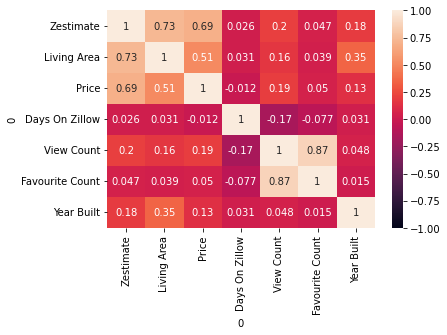

In [222]:
data = data[data.Price != '--']
vars_to_look_at = single_families_home[["Zestimate", "Living Area", "Price", "Days On Zillow", "View Count", "Favourite Count", "Year Built"]].dropna().astype(float)
#vars_to_look_at = vars_to_look_at.dropna()
sns.heatmap(vars_to_look_at.corr(), vmin=-1, vmax=1, annot=True)

# Scatterplot of View Count vs. Days on Zillow

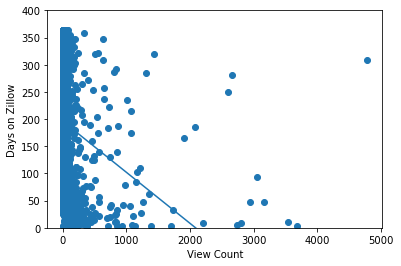

In [120]:
plt.scatter(sample_data["View Count"], sample_data["Days On Zillow"])
res = linregress(list(sample_data["View Count"]), list(sample_data["Days On Zillow"]))
fx = np.array( [min(list(sample_data["View Count"])), max(list(sample_data["View Count"])) ])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy)
plt.ylim([0, 400])
plt.xlabel("View Count")
plt.ylabel("Days on Zillow")
plt.show()

* find the average time it takes for a house to sell --> determine fast by the 1st quartile and slow by the 3rd quartile 
    * Fast: less than 104 days
    * Medium: 104-280 Days
    * Slow: more than 280 days (max of 501 days)
* find the average time it takes for a house for single homes & has sold
    * Fast: less than 106 days
    * Medium: 106-195 Days
    * Slow: more than 279 days (max of 364 days)

In [359]:
data[["Days On Zillow"]].astype(float).describe()
single_families_home[["Days On Zillow"]].astype(float).describe()

,Days On Zillow
count,19331.000000
mean,192.404687
std,100.579872
min,1.000000
25%,106.000000
50%,195.000000
75%,279.000000
max,364.000000


<AxesSubplot:xlabel='Zipcode', ylabel='Days On Zillow'>

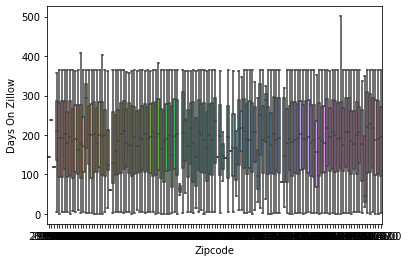

In [221]:
zipcode = data[["Zipcode", "Days On Zillow"]].astype(float)
new = zipcode.groupby(["Zipcode"])[["Days On Zillow"]]

sns.boxplot(x = zipcode["Zipcode"], y = zipcode["Days On Zillow"])

# Analysis of Agency

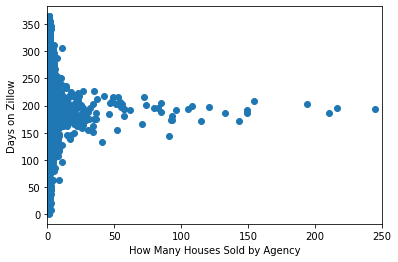

In [13]:
# Problem: 2500 different agencies so hard to display - Analyzing Agencies
agents = single_families_home[["Agency", "Days On Zillow"]].dropna()
agents.columns = [string.replace(" ", "_").lower() for string in list(agents.columns)]
agents[["days_on_zillow"]] = agents[["days_on_zillow"]].astype(float)
new = agents.groupby(["agency"]).describe()

plt.scatter(x = new.days_on_zillow["count"], y = new.days_on_zillow["mean"])
plt.xlim([0, 250])
plt.xlabel("How Many Houses Sold by Agency")
plt.ylabel("Days on Zillow")
plt.show()

# Which Agencies Sell Houses Fast

In [15]:
single_families_home["Days On Zillow"].astype(float).describe()
new.days_on_zillow[(new.days_on_zillow["mean"] < 106) & (new.days_on_zillow["count"] > 5)]

,count,mean,std,min,25%,50%,75%,max
agency,,,,,,,,
"Griffin Real Estate, Inc.",11.0,96.545455,80.111627,19.0,53.00,61.0,120.50,268.0
"REX-Real Estate Exchange, Inc",9.0,63.666667,39.708311,6.0,32.00,70.0,80.00,123.0
United Real Estate Los Angeles,6.0,85.333333,77.732018,8.0,31.75,64.5,121.25,214.0


# AC/Heating Affects

In [17]:
Cooling_Heating = single_families_home[["Has Cooling", "Cooling", "Has Heating", "Heating", "Days On Zillow"]].dropna()

Cooling_Heating.columns = [string.replace(" ", "_").lower() for string in list(Cooling_Heating.columns)]
recode = {'TRUE' : True, 'False' : False, True : True, False : False}
Cooling_Heating.has_cooling = Cooling_Heating.has_cooling.map(recode)
Cooling_Heating.has_heating = Cooling_Heating.has_heating.map(recode)

In [18]:
avr_cooling_heating = Cooling_Heating[(Cooling_Heating["has_cooling"] == True) & (Cooling_Heating["has_heating"] == True)]["days_on_zillow"]
avr_cooling = Cooling_Heating[(Cooling_Heating["has_cooling"] == True) & (Cooling_Heating["has_heating"] == False)]["days_on_zillow"]
avr_heating = Cooling_Heating[(Cooling_Heating["has_cooling"] == False) & (Cooling_Heating["has_heating"] == True)]["days_on_zillow"]
avr_none = Cooling_Heating[(Cooling_Heating["has_cooling"] == False) & (Cooling_Heating["has_heating"] == False)]["days_on_zillow"]

#values = pd.array(avr_cooling_heating, avr_cooling, avr_heating, avr_none)
#labels = list("Both", "Cooling", "Heating", "None")
#pd.DataFrame({"Both": avr_cooling_heating, "Cooling": avr_cooling, "Heating": avr_heating, "None": avr_none})
label = ["Both", "Cooling", "Heating", "None"]
data_cool_heat = [avr_cooling_heating, avr_cooling, avr_heating, avr_none]

{'whiskers': [<matplotlib.lines.Line2D at 0x18885c041c0>,
 'caps': [<matplotlib.lines.Line2D at 0x18885c04760>,
 'boxes': [<matplotlib.patches.PathPatch at 0x18885bf4ee0>,
 'medians': [<matplotlib.lines.Line2D at 0x18885c04d00>,
 'fliers': [<matplotlib.lines.Line2D at 0x18885c04fd0>,
 'means': []}

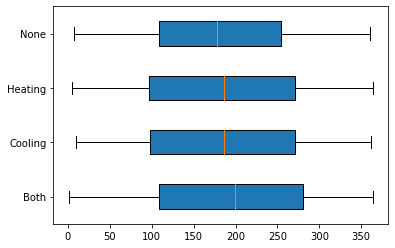

In [342]:
plt.boxplot(data_cool_heat, vert=False, patch_artist=True, labels = label)

In [375]:
# Do Side by Side Box & Whisker Plot for different heating
heating_sys = Cooling_Heating[["heating", "days_on_zillow"]]
heating_sys[["days_on_zillow"]] = heating_sys[["days_on_zillow"]].astype(float)
heating_sys = heating_sys.groupby("heating")

# Zestimate vs. Selling Price

In [20]:
data_new = pd.read_csv("zillow_added_variables.csv")

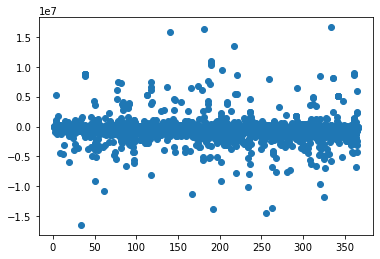

In [69]:
take_out_outliers = data_new[data_new["pricedif"] < 100000000]

x_vals = take_out_outliers["days_on_zillow"]
y_vals = take_out_outliers["pricedif"]

plt.scatter(x = x_vals, y = y_vals)

res = linregress(list(x_vals), list(y_vals))
fx = np.array( [min(list(x_vals)), max(list(x_vals)) ])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy)

plt.show()

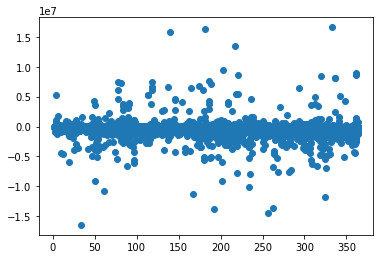

In [22]:
take_out_outliers = data_new[data_new["pricedif"] < 100000000]
take_out_outliers = take_out_outliers[(take_out_outliers["property_type"] == "SINGLE_FAMILY") & (take_out_outliers["property_status"] == "RECENTLY_SOLD")]


x_vals = take_out_outliers["days_on_zillow"]
y_vals = take_out_outliers["pricedif"]

plt.scatter(x = x_vals, y = y_vals)

res = linregress(list(x_vals), list(y_vals))
fx = np.array( [min(list(x_vals)), max(list(x_vals)) ])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy)

plt.show()

In [22]:
(take_out_outliers[["days_on_zillow"]]).describe()

,days_on_zillow
count,24836.000000
mean,194.705790
std,101.273631
min,1.000000
25%,109.000000
50%,199.000000
75%,282.000000
max,366.000000


In [23]:
(take_out_outliers[["num_words"]]).describe()

,num_words
count,16343.00000
mean,140.95160
std,74.23891
min,1.00000
25%,81.00000
50%,142.00000
75%,190.00000
max,567.00000


In [24]:
(take_out_outliers[["pricedif"]]).describe()

,pricedif
count,1.634300e+04
mean,-1.692225e+05
std,6.761808e+05
min,-1.643630e+07
25%,-1.828500e+05
50%,-9.330000e+04
75%,-4.820000e+04
max,1.659220e+07


Something to note, if pricediff is positive, then the house sold for more than what was expected. 

Take a look at a bar chart: response variable number of words / characters
* column for houses that had negative price diff but took longer to sell (don't expect)
* column for houses that had positive price diff but were quick to sell (don't expect)
* column for houses that had negative price diff but were quick to sell (expect)
* column for houses that had positive price diff but took longer to sell (expect) 

Facts:
* Average days on zillow is 194 days
* Quartile 1: 106 days & Quartile 3: 282 days
* Average pricediff is -$170,000 so the houses are selling for less that what is expected
* Average number of characters in 837, Average number of words is 140

# Separate by % Above Cost
new_var = (price - zestimate ) / zestimate

In [27]:
take_out_outliers["percent_above_zillow"] = take_out_outliers.apply(lambda row: (row.price - row.zestimate) / row.zestimate, axis = 1)

In [28]:
(take_out_outliers[["percent_above_zillow"]]).describe()

,percent_above_zillow
count,24836.000000
mean,-0.082885
std,0.360707
min,-0.999921
25%,-0.112811
50%,-0.079834
75%,-0.043621
max,17.684269


In [31]:
# Take out Outlier
percent_data = take_out_outliers[(take_out_outliers["percent_above_zillow"] > -1.165) & (take_out_outliers["percent_above_zillow"] < 0.999)]

In [32]:
(percent_data[["percent_above_zillow"]]).describe()

,percent_above_zillow
count,24737.000000
mean,-0.098983
std,0.145192
min,-0.999921
25%,-0.112971
50%,-0.080144
75%,-0.043943
max,0.994813


# Natural Language Processing

Ideas: 
* classify between slow, medium, and fast and see which are the most popular terms
* Keyword/topic Extraction
* LDA <-- more or less my task
lower all of the terms, lemitize them <-- dictionary 

Isolate ones with different Zestimate/Actual selling price
* clustering
* what factors are important in selecting a house
* how to train machine learning algorhytm: bad/good desciption

In [36]:
slow = percent_data[(percent_data["days_on_zillow"] > 282) & (percent_data["pricedif"] > -38000)]
slow_mean = slow["num_words"]

slow_but_supposed_fast = percent_data[(percent_data["days_on_zillow"] > 282) & (percent_data["pricedif"] < -182850)]
slow_but_supposed_fast_mean = slow_but_supposed_fast["num_words"]

fast = percent_data[(percent_data["days_on_zillow"] < 106) & (percent_data["pricedif"] < -182850)]
fast_mean = fast["num_words"]

fast_supposed_slow = percent_data[(percent_data["days_on_zillow"] < 106) & (percent_data["pricedif"] > -38000)]
fast_supposed_slow_mean = fast_supposed_slow["num_words"]



fast_slow = [slow_mean, slow_but_supposed_fast_mean, fast_mean, fast_supposed_slow_mean]
label = ["Slow", "Slow But Supoosed to be Fast", "Fast", "Fast But Supposed to be Slow"]

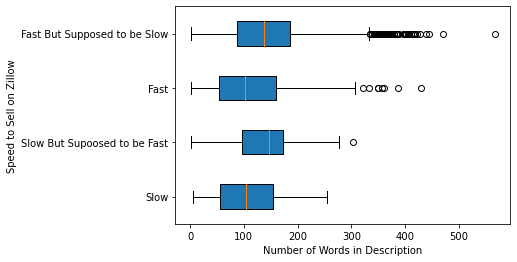

In [37]:
plt.boxplot(fast_slow, vert=False, patch_artist=True, labels = label)
plt.xlabel("Number of Words in Description")
plt.ylabel("Speed to Sell on Zillow")
plt.show()

In [40]:
slow_p = percent_data[(percent_data["days_on_zillow"] > 279) & (percent_data["percent_above_zillow"] > -0.043943)]
slow_mean_p = slow["num_words"]

slow_but_supposed_fast_p = percent_data[(percent_data["days_on_zillow"] > 279) & (percent_data["percent_above_zillow"] < -0.112971)]
slow_but_supposed_fast_mean_p = slow_but_supposed_fast_p["num_words"]

fast_p = percent_data[(percent_data["days_on_zillow"] < 106) & (percent_data["percent_above_zillow"] < -0.112971)]
fast_mean_p = fast["num_words"]

fast_supposed_slow_p = percent_data[(percent_data["days_on_zillow"] < 106) & (percent_data["percent_above_zillow"] > -0.043943)]
fast_supposed_slow_mean_p = fast_supposed_slow_p["num_words"]



fast_slow = [slow_mean_p, slow_but_supposed_fast_mean_p, fast_mean_p, fast_supposed_slow_mean_p]
label = ["Slow", "Slow But Supoosed to be Fast", "Fast", "Fast But Supposed to be Slow"]

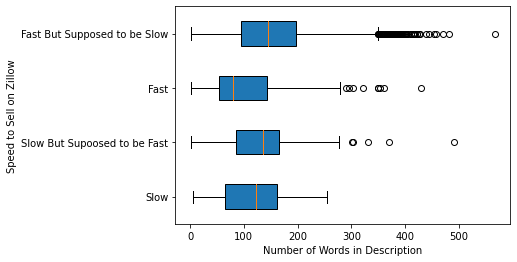

In [41]:
plt.boxplot(fast_slow, vert=False, patch_artist=True, labels = label)
plt.xlabel("Number of Words in Description")
plt.ylabel("Speed to Sell on Zillow")
plt.show()

# Adding to Data for Better NLP

In [48]:
new_precent_data = percent_data[percent_data["property_type"] == "SINGLE_FAMILY"]
new_precent_data = new_precent_data[["days_on_zillow", "zestimate", "price", "pricedif", "description", "num_words", "num_chars", "percent_above_zillow"]]

speed_condition = [
    (new_precent_data["days_on_zillow"] <= 106),
    (new_precent_data["days_on_zillow"] > 106) & (new_precent_data["days_on_zillow"] < 279),
    (new_precent_data["days_on_zillow"] >= 279)
]
speed_values = ["slow", "medium", "fast"]


percent_condition = [
    (new_precent_data["percent_above_zillow"] >= -0.043943),
    (new_precent_data["percent_above_zillow"] < -0.043943) & (new_precent_data["percent_above_zillow"] > -0.112971),
    (new_precent_data["percent_above_zillow"] <= -0.112971)
]
percent_values = ["higher", "normal", "lower"] 

data_for_nlp = new_precent_data
data_for_nlp["selling_speed"] = np.select(speed_condition, speed_values)
data_for_nlp["selling_percent"] = np.select(percent_condition, percent_values)

In [54]:
import pandas as pd
import numpy as np 
from tqdm import tqdm, tqdm_pandas
tqdm.pandas()
import os
import ast
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import spacy
import textstat

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\derek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\derek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [57]:
data_for_nlp["reading_ease"] = data_for_nlp.description.progress_apply(lambda x: textstat.flesch_reading_ease(x))
data_for_nlp["grade_level"] = data_for_nlp.description.progress_apply(lambda x: textstat.text_standard(x, float_output = True))
data_for_nlp["reading_time"] = data_for_nlp.description.progress_apply(lambda x: textstat.reading_time(x, ms_per_char=14.69))
data_for_nlp["sentence_count"] = data_for_nlp.description.progress_apply(lambda x: textstat.sentence_count(x))

100%|██████████| 16395/16395 [00:00<00:00, 16532.21it/s]


In [ ]:
nlp = spacy.load("en_core_web_sm")
from nltk.tokenize import RegexpTokenizer

def text_clean(string):
    words = []
    tokenizer = RegexpTokenizer((r'\w+')) # load function that tokenizes into words and keeps only alphanumeric characters 
    text = tokenizer.tokenize(string.lower()) # tokenize the input and lower every word
    text = nlp(" ".join(text)) 
    for token in text:
        # remove stopwords and lemmatize rest 
        if token.is_stop == False:
            words += [token.lemma_]
    return (" ").join(words)

data_for_nlp["clean_description"] = data_for_nlp.description.progress_apply(text_clean)

100%|██████████| 16395/16395 [06:45<00:00, 40.46it/s]


In [ ]:
data_for_nlp["categories"] = data_for_nlp.apply(lambda row: "sold_" + str(row.selling_speed) + "_" + str(row.selling_percent) + "_cost", axis = 1)